In [28]:
from __future__ import print_function
import time

import numpy as np
np.random.seed(1234)
from functools import reduce
import math as m

import scipy.io


from scipy.interpolate import griddata
from sklearn.preprocessing import scale




def gen_images(locs, features, n_gridpoints, normalize=True,
               std_mult=0.1, n_components=2):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode
    :param locs: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param n_gridpoints: Number of pixels in the output images
    :param normalize:   Flag for whether to normalize each band over all samples
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes

    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    n_colors = features.shape[1] // nElectrodes
    for c in range(n_colors):
        feat_array_temp.append(features[:, c * nElectrodes : nElectrodes * (c+1)])

    n_samples = features.shape[0]

    # Interpolate the values
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints*1j,
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints*1j
                     ]
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([n_samples, n_gridpoints, n_gridpoints]))

    # Interpolating
    for i in range(n_samples):
        for c in range(n_colors):
            temp_interp[c][i, :, :] = griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),
                                               method='cubic', fill_value=np.nan)

    for c in range(n_colors):
        if normalize:
            temp_interp[c][~np.isnan(temp_interp[c])] = \
                scale(temp_interp[c][~np.isnan(temp_interp[c])])
        temp_interp[c] = np.nan_to_num(temp_interp[c])
    return np.swapaxes(np.asarray(temp_interp), 0, 1)     # swap axes to have [samples, colors, W, H]


def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]

    #Y[0] = 0
    return frq,abs(Y)

def theta_alpha_beta_averages(f,Y):
    theta_range = (4,7)
    alpha_range = (8,12)
    beta_range = (13,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

def make_frames(df,frame_duration):
    
    #in: dataframe or array with all channels, frame duration in seconds
    #out: array of theta, alpha, beta averages for each probe for each time step
    #shape: (n-frames,m-probes,k-brainwave bands)
    
    Fs = 128.0
    frame_length = Fs*frame_duration
    frames = []
    frames_ar_alpha= []
    frames_ar_theta= []
    frames_ar_beta= []
    steps = np.arange(0,len(df),frame_length)
    for i,_ in enumerate(steps):
        frame = []
        ar_alpha= []
        ar_theta= []
        ar_beta= []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.iloc[steps[i-1]:steps[i]-1,int(channel)])
                #print(i, channel)
                f,Y =  get_fft(snippet)
                theta = theta_alpha_beta_averages(f,Y)
                #print theta, alpha, beta
                #ar_alpha.append([alpha])
                #ar_theta.append([theta])
                #ar_beta.append([beta])
                frame.append([theta])
            
        frames.append(frame)
        '''        
        print("________________Frame_no {"+str(i)+"}________________")
        plt.figure(figsize=(50, 6))
        plt.plot(ar_theta,color='green',label='theta')
        plt.plot(ar_alpha,color='blue',label='alpha')
        plt.plot(ar_beta,color='red', label='beta' )
        plt.legend()
        #plt.xlabel('sampled time',fontsize=35)
        #plt.ylabel('Hz',fontsize=35)
        #plt.title('EEG channel '+str(d[i]), fontsize=35)
        plt.xlabel('Sensors')
        plt.ylabel('AVG (freq)');
        plt.show()
        '''
    #print(len(frames))
    
    return np.array(frames)

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
import matplotlib.pyplot as plt


%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4
val=1


In [25]:
locs_2d = [(-2.0,4.0), #af3
                   (2.0,4.0), #af4
                   (-1.0,3.0),#f3
                   (1.0,3.0),#f4
                   (-3.0,3.0),#f7
                   (3.0,3.0),#f8
                   (-2.0,2.0),#fc5
                   (2.0,2.0),#fc6
                   (-2.0,-2.0),#p7
                   (2.0,-2.0),#p8
                   (-4.0,1.0),#t7
                   (4.0,1.0),#t8
                   (-1.0,-3.0),#o1
                   (1.0,-3.0)] #o2

In [17]:

ar_all=[]

#create 40 csv files for each subject

for sub_name in range(1,33):
    print('sub'+str(sub_name))
    for trial in range(0,40):
        print("trail"+str(trial))
        dat=[]
        if sub_name<10:
            fname = "/home/vikmachine/Desktop/research/MAIN/mainprog/data/s0"+str(sub_name)+".dat"
        else:
            fname = "/home/vikmachine/Desktop/research/MAIN/mainprog/data/s"+str(sub_name)+".dat"
        f = open(fname, 'rb')                 #Read the file in Binary mode
        x = pickle.load(f, encoding='latin1')
        data=x['data']
        dat.append([])
        for j in range(0, 8064):
            dat[0].append(data[trial][1][j]) #0
        dat.append([])
        for j in range(0, 8064):
            dat[1].append(data[trial][17][j])
        dat.append([])
        for j in range(0, 8064):
            dat[2].append(data[trial][2][j])
        dat.append([])
        for j in range(0, 8064):
            dat[3].append(data[trial][19][j])
        dat.append([])
        for j in range(0, 8064):
            dat[4].append(data[trial][3][j])
        dat.append([])
        for j in range(0, 8064):
            dat[5].append(data[trial][20][j])
        dat.append([])
        for j in range(0, 8064):
            dat[6].append(data[trial][4][j]) 
        dat.append([])
        for j in range(0, 8064):
            dat[7].append(data[trial][21][j])
        dat.append([])
        for j in range(0, 8064):
            dat[8].append(data[trial][11][j])
        dat.append([])
        for j in range(0, 8064):
            dat[9].append(data[trial][29][j])
        dat.append([])
        for j in range(0, 8064):
            dat[10].append(data[trial][7][j])
        dat.append([])
        for j in range(0, 8064):
            dat[11].append(data[trial][25][j])#13
        dat.append([])
        for j in range(0, 8064):
            dat[12].append(data[trial][13][j]) #25
        dat.append([])
        for j in range(0, 8064):
            dat[13].append(data[trial][31][j])
        
        



        '''
        d=['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2','hEOG (horizontal EOG, hEOG1 - hEOG2)','vEOG (vertical EOG, vEOG1 - vEOG2)','zEMG (Zygomaticus Major EMG, zEMG1 - zEMG2)','tEMG (Trapezius EMG, tEMG1 - tEMG2)','GSR (values from Twente converted to Geneva format (Ohm))','Respiration belt','Plethysmograph','Temperature']
        sns.set()
        for i in range(0, 32):
            plt.figure(figsize=(50, 6))
            plt.plot(dat[i])
            plt.xlabel('sampled time',fontsize=35)
            plt.ylabel('Hz',fontsize=35)
            plt.title('EEG channel '+str(d[i]), fontsize=35)
            plt.show()
        '''

        df = pd.DataFrame(dat)
        df=df.T
        df.to_csv('/home/vikmachine/Desktop/research/subjects_data/subject'+str(sub_name)+'_trial'+str(trial)+'.csv')
        #df. info()


sub1
trail0
trail1
trail2
trail3
trail4
trail5
trail6
trail7


KeyboardInterrupt: 

In [29]:
def make_data_pipeline(file_names,labels,image_size,frame_duration,overlap):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    Fs = 128.0   #sampling rate
    frame_length = Fs * frame_duration
    
    print('Generating training data...')
    
    
    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        
        data=pd.read_csv(file)
        data=data.drop(['Unnamed: 0'], axis=1)
        df = pd.DataFrame(data)
        #print(df)
        
        X_0 = make_frames(df,frame_duration)
        #steps = np.arange(0,len(df),frame_length)
        X_1 = X_0.reshape(len(X_0),14*3)
        
        images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False)
        images = np.swapaxes(images, 1, 3) 
        print(len(images), ' frames generated with label ', labels[i], '.')
        print('\n')
        print(labels[0])
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)
        
    print(X)
    return X,np.array(y)

In [30]:
file_names=[]
for sub_name in range(1,33):
    print('sub'+str(sub_name))
    for trial in range(0,40):
        file_names.append('/home/vikmachine/Desktop/research/subjects_data/subject'+str(sub_name)+'_trial'+str(trial)+'.csv')
len(file_names)

label=[]
labels=[]
with open('/home/vikmachine/Desktop/research/MAIN/mainprog/data/label_class_0.dat') as scores:
    for line in scores:
        splitted_line = line.split(' ')
        for values in splitted_line:
            value_as_int = int(values)
            labels.append(value_as_int)

    
image_size = 28
frame_duration = 2.0
overlap = 0.5
X, y = make_data_pipeline(file_names, labels, image_size, frame_duration, overlap)

sub1
sub2
sub3
sub4
sub5
sub6
sub7
sub8
sub9
sub10
sub11
sub12
sub13
sub14
sub15
sub16
sub17
sub18
sub19
sub20
sub21
sub22
sub23
sub24
sub25
sub26
sub27
sub28
sub29
sub30
sub31
sub32
Generating training data...
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject1_trial0.csv . ( 1  of  1280 )


TypeError: cannot do slice indexing on <class 'pandas.core.indexes.range.RangeIndex'> with these indexers [0.0] of <class 'numpy.float64'>

In [9]:
X.shape

(39680, 28, 28, 3)

In [11]:
#y=y.reshape(1280*31)
#y=y.reshape(15360)
y.shape

(39680,)

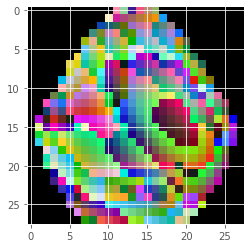

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.imshow(X[71433])
plt.imshow((X[3955]* 255).astype(np.uint8))
#print(X[798])

In [21]:
# input image dimensions
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30,shuffle=True)
img_rows, img_cols = 28, 28

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

x_train shape: (27776, 28, 28, 3)
27776 train samples
11904 test samples


In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

/home/vikmachine/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vikmachine/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vikmachine/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vikmachine/anaconda3/lib/python3.7/site-packages/tensorflow/pyth

In [23]:
import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from keras.layers import Dense, Dropout, Activation, Flatten, ConvLSTM2D
from keras.layers import Conv2D, MaxPooling2D
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess=tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))



batch_size = 128
num_classes = 2
epochs = 200

dense_layers = [2]
layer_sizes = [32,128]
conv_layers = [3]

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


In [24]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "(valence){}-conv-{}-nodes-{}-dense-{}".format(conv_layer,layer_size,dense_layer,int(time.time()))
            print(NAME)
            tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
            model = Sequential()
            model.add(Conv2D(32, (3, 3), padding='same',input_shape=(28,28,3)))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            
            for i in range(conv_layer-1):
                model.add(Conv2D(32, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())
            
            for i in range(dense_layer-1):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))
                
            model.add(Dropout(0.5))
            model.add(Dense(num_classes))
            model.add(Activation('sigmoid'))

            # initiate RMSprop optimizer
            opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

            # Let's train the model using RMSprop
            model.compile(loss='binary_crossentropy',
                          optimizer=opt,
                          metrics=['accuracy'])

            model.summary()
            model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_test, y_test),
                      shuffle=True,callbacks=[tensorboard])

            

(valence)3-conv-32-nodes-2-dense-1588375655

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)  

KeyboardInterrupt: 

In [15]:
keras.backend.clear_session()

In [16]:
#from keras.models import load_modelX=X.reshape(1280,31,28,28,3)
X=X.reshape(1280,31,28,28,3)
X.shape

(1280, 31, 28, 28, 3)

In [17]:
label=[]
labels=[]
with open("/home/vikmachine/Desktop/research/MAIN/mainprog/data/label_class_0.dat") as scores:
    for line in scores:
        splitted_line = line.split(' ')
        for values in splitted_line:
            value_as_int = int(values)
            labels.append(value_as_int)

Y=np.asarray(labels)
Y.shape

(1280,)

In [18]:
# input image dimensions
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20,shuffle=True)
img_rows, img_cols = 28, 28

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

x_train shape: (1024, 31, 28, 28, 3)
1024 train samples
256 test samples


In [19]:
import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, ConvLSTM2D
from keras.layers import Conv2D, MaxPooling2D

batch_size = 128
num_classes = 2
epochs = 1

nb_filters=32
kernel_size=(3,3)
pool_size=(2,2)
nb_classes=2
batch_size=62

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess=tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [21]:
    import datetime
    import tensorflow as tf
    import keras
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten, ConvLSTM2D
    from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, Reshape, LSTM, GRU, BatchNormalization
    from keras.models import Model
    from keras.optimizers import SGD
    batch_size = 5
    num_classes = 2
    epochs = 1

    nb_filters=32
    kernel_size=(3,3)
    pool_size=(2,2)
    nb_classes=2
    batch_size=62
    
    #values below were changed according to test cases


    model = Sequential()
    # first layer
    model.add(TimeDistributed(Conv2D(128,(3,3), padding='same', data_format="channels_last"), 
                              input_shape=(31,28,28,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(Dropout(0.3))

    # hidden layer
    
    model.add(TimeDistributed(Conv2D(16,(3,3), padding='same', data_format="channels_last") 
                              ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(Dropout(0.3))

    # hidden layer

    model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(Dense(128)))
    model.add(Activation('relu'))
    model.add(Dropout(0.15))

    # output layer
    # Change size of layer follow experiment design
    model.add(LSTM(32, recurrent_dropout=0.3 ,return_sequences=True, implementation=1))
    model.add(Dropout(0.3))
    model.add(LSTM(16, recurrent_dropout=0.3,return_sequences=False, implementation=1))
    model.add(Dropout(0.3))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    model.summary()
    opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-7)
    
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics= ['accuracy'])
    
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=False)
    
model.save('Valency_lstm_model.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 31, 28, 28, 128)   3584      
_________________________________________________________________
batch_normalization_3 (Batch (None, 31, 28, 28, 128)   512       
_________________________________________________________________
activation_5 (Activation)    (None, 31, 28, 28, 128)   0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 31, 14, 14, 128)   0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 31, 14, 14, 128)   0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 31, 14, 14, 16)    18448     
_________________________________________________________________
batch_normalization_4 (Batch (None, 31, 14, 14, 16)   